# Assignment 2 - Classification

_Tiffany Wang - 260684152_ 

In [56]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 
import os
from PIL import Image

In [77]:
def HoG_features(images, cell_size=(4, 4), block_size=(4, 4), nbins=8):
    '''
    Creates a list of HoG features for each image. 
    :param images: list of images to be processed
    :param cell_size: shape of pixels window per cell 
    :param block_size: shape of cells window per block 
    :return: list of HoG features 
    '''
    features = []
    for img in images:
        h, w, _ = img.shape
        c_h, c_w = cell_size
        b_h, b_w = block_size
        
        # create HoG Object
        hog = cv2.HOGDescriptor(_winSize=(w // c_w * c_w, h // c_h * c_h),
                                _blockSize=(b_w * b_w, b_h * b_h),
                                _blockStride=(c_w, c_h),
                                _cellSize=(c_w, c_h),
                                _nbins=nbins)

        n_cells = (h // c_h, w // c_w)

        # Compute HoG features
        hog_feats = hog.compute(img) \
                       .reshape(n_cells[1] - b_w + 1, n_cells[0] - b_h + 1, b_h, b_w, nbins) \
                       .transpose((1, 0, 2, 3, 4))  
        
        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(b_h):
            for off_x in range(b_w):
                gradients[off_y:n_cells[0] - b_h + off_y + 1, 
                          off_x:n_cells[1] - b_w + off_x + 1] += hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - b_h + off_y + 1,
                           off_x:n_cells[1] - b_w + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count

        features.append(gradients)
    return features

###### 1. Resize the training images to 128 x 128.

In [75]:
# Load images and store them in training and test sets 
data = os.listdir('./dataset/')
ford_train = []
ford_test = []
vw_train = []
vw_test = []
size = (128, 128)

# Resize and store training and test images 
for file in data: 
    img = Image.open('./dataset/' + file)
    
    if (len(img.size) == 2): 
        img = img.convert('RGB')        
    img = img.resize(size)
    img = np.array(img)
    if file.startswith('ford_train'): 
        ford_train.append(img)
    elif file.startswith('ford_test'):
        ford_test.append(img)
    elif file.startswith('volks_train'): 
        vw_train.append(img)
    elif file.startswith('volks_test'): 
        vw_test.append(img)  
        
print('{} Ford training images'.format(len(ford_train)))
print('{} Ford training images'.format(len(ford_test)))
print('{} Volkswagen training images'.format(len(vw_train)))
print('{} Volkswagen training images'.format(len(vw_test)))

5 Ford training images
1 Ford training images
5 Volkswagen training images
1 Volkswagen training images


###### 2. Compute HoG features of size (32,32,8). Apply blocknorm in 4 x 4 cell neighborhood.

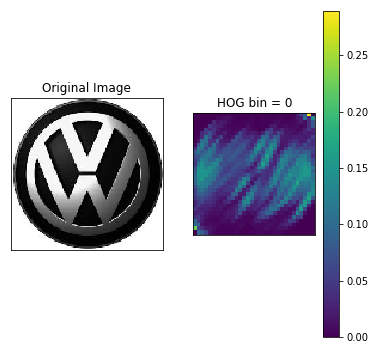

In [78]:
# img.shape = (128, 128, 3), so cell_size = (128 // 4, 128 // 4)
ford_features = HoG_features(ford_train)
vw_features = HoG_features(vw_train)

# test the feature extraction for one image 
img = vw_train[3]
gradients = vw_features[3]

# Preview
plt.figure(figsize = (6,6))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.pcolor(gradients[:, :, 0])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("HOG bin = 0"), plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

In [38]:
from sklearn.neighbors import KNeighborsClassifier

# set up classifier
train_x = np.array(ford_features + vw_features)
train_x = train_x.reshape(train_x.shape[0], -1)
nb_ford_train = len(ford_train)
nb_vw_train = len(vw_train)

# create labels for training set
train_y = ['ford' for _ in range(nb_ford_train)] + ['volkswagen' for _ in range(nb_vw_train)]

# Instantiate classifier and train. 
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_x, train_y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

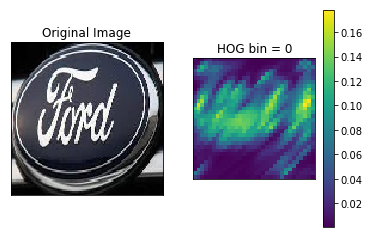

The image above was classified as ford


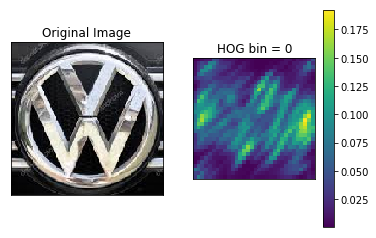

The image above was classified as volkswagen


In [37]:
##################
# PREDICT IMAGES #
##################
test_img = ford_test + vw_test
test_features = np.array(HoG_features(test_img))
test_y = neigh.predict(test_features.reshape(len(test_img), -1))
for x, x_ft, y in zip(test_img, test_features, test_y):
    # Preview
    plt.figure(figsize = (6,4))
    plt.subplot(121)
    plt.imshow(x, cmap='gray')
    plt.title("Original Image"), plt.xticks([]), plt.yticks([])

    plt.subplot(122)
    plt.pcolor(x_ft[:, :, 0])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("HOG bin = 0"), plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.show()
    
    print('The image above was classified as', y)